# Predicting the DST current index from other variables

## Downloading data

We will first download low-resolution data from [OMNI](https://omniweb.gsfc.nasa.gov/), and split it into a training and a test set.


In [1]:
from datetime import datetime
from aidapy import load_data
from sklearn.model_selection import train_test_split

# Set the start and end date as year, month, day
t0 = datetime(2000, 1, 1)
t1 = datetime(2015, 12, 31)

# Download the data
omnixr = load_data(mission='omni', start_time=t0, end_time=t1)

# Store data in pandas format
pd_data = omnixr['all1'].to_pandas()

# Split into training and test data
dtrain, dtest = train_test_split(pd_data, shuffle=False)

pd_data.describe()

100.0% 2883584 / 2881152


100.0% 2875392 / 2873280


100.0% 2875392 / 2873280


100.0% 2875392 / 2873280


100.0% 2883584 / 2881152


products,Bartels Rotation Number,ID IMF Spacecraft,ID SW Plasma Spacecraft,points(IMF Average),points(Plasma Average),|B|,Magnitude of Avg Field Vector,Lat. Angle of Aver. Field Vector,Long. Angle of Aver. Field Vector,"Bx GSE, GSM",...,Proton Flux > 10MeV,Proton Flux > 30MeV,Proton Flux > 60MeV,flag,ap index,f10.7 index,PC(N) index,AL index (Kyoto),AU index (Kyoto),Magnetosonic Mach No.
count,140233.000000,140233.000000,140105.000000,140233.000000,140105.000000,140233.000000,140233.000000,140233.000000,140233.000000,140233.000000,...,113159.000000,113134.000000,113120.000000,140233.000000,140233.000000,140113.000000,140035.000000,140233.000000,140233.000000,135984.000000
mean,2379.926836,55.852353,56.569801,48.675333,30.049670,5.827601,5.174818,0.130479,201.635718,-0.004155,...,7.994024,2.036895,0.759653,-0.807028,10.408599,116.238255,0.960367,-110.092596,68.026370,5.641059
std,62.473060,8.573346,8.166480,19.356001,9.397953,3.219993,3.069832,29.213007,100.877033,3.473102,...,152.075039,48.944587,18.042820,0.394632,16.728629,43.382109,1.345067,143.618415,70.739359,1.158862
min,2272.000000,51.000000,45.000000,1.000000,1.000000,0.400000,0.100000,-89.200000,0.000000,-40.800000,...,0.010000,0.010000,0.010000,-1.000000,0.000000,65.100000,-21.500000,-2452.000000,-260.000000,0.600000
25%,2326.000000,51.000000,52.000000,51.000000,17.000000,3.800000,3.200000,-18.500000,122.300000,-2.500000,...,0.150000,0.080000,0.060000,-1.000000,3.000000,78.500000,0.100000,-148.000000,20.000000,4.900000
50%,2380.000000,51.000000,52.000000,59.000000,35.000000,5.100000,4.500000,-0.100000,181.100000,0.000000,...,0.200000,0.110000,0.080000,-1.000000,6.000000,107.100000,0.600000,-49.000000,42.000000,5.700000
75%,2434.000000,51.000000,52.000000,60.000000,37.000000,7.000000,6.200000,18.600000,302.000000,2.400000,...,0.250000,0.150000,0.110000,-1.000000,12.000000,141.200000,1.500000,-20.000000,91.000000,6.400000
max,2488.000000,71.000000,71.000000,94.000000,74.000000,62.000000,60.700000,89.800000,360.000000,34.800000,...,9650.000000,3220.000000,1220.000000,0.000000,400.000000,325.100000,28.000000,22.000000,1226.000000,12.700000


## Let's have a look at the data

Below, the DST index is shown. Note that there are quiet periods, and periods with more magnetic storms, indicated by large negative values.

<IPython.core.display.Javascript object>


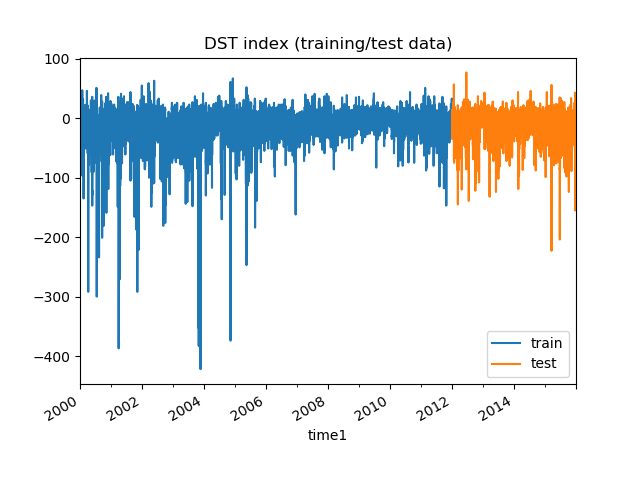

In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib notebook
register_matplotlib_converters()

plt.figure()
plt.title("DST index (training/test data)")
dtrain['DST Index'].plot(label='train')
dtest['DST Index'].plot(label='test')
plt.gcf().autofmt_xdate()
plt.legend();

## The correlation between the DST Index and other variables

Let's have a look at the linear correlation between the DST index and other variables. Correlations range from -1 (anti-correlation) to 1 (perfect correlation), and a value around zero indicates the variables are linearly independent. (However, there might be a complex non-linear correlation)

In [3]:
# Generate a correlation matrix
corr_matrix = dtrain.corr()

# Get the correlation with the DST index
dst_corr = corr_matrix['DST Index']

# Display correlations sorted by absolute value
ix = dst_corr.abs().sort_values(ascending=False).index
sorted_corr = dst_corr.reindex(ix)

# Print the variables with the strongest correlations
print(sorted_corr[:10])

products
DST Index                        1.000000
ap index                        -0.629716
Kp                              -0.573182
AL index (Kyoto)                 0.548138
AE Index                        -0.542807
PC(N) index                     -0.514771
Plasma Flow Speed               -0.456372
AU index (Kyoto)                -0.420654
|B|                             -0.396887
Magnitude of Avg Field Vector   -0.386568
Name: DST Index, dtype: float64


## Selecting features

We will now select *features* from which we will predict the DST Index (our target). There are a number of other indices that the DST correlates to, but to make this example somewhat challenging we will exclude them!

In [4]:
# Get names of the variables
all_names = list(sorted_corr.index)

# Remove index variables
my_names = [name for name in all_names if 'ndex' not in name]

# Remove other variables
my_names.remove('Kp')

# Select variables with the strongest (absolute) correlations as features
n_features = 5
features = my_names[:n_features]
targets = ['DST Index']
all_vars = features + targets
print("The features are: ", features)
print("The targets are: ", targets)

# Remove rows with missing values. We do this after selecting features,
# otherwise we remove too many rows.
dtrain_dropna = dtrain[all_vars].dropna()
dtest_dropna = dtest[all_vars].dropna()

# Get the features and targets
X_train = dtrain_dropna[features].values
y_train = dtrain_dropna[['DST Index']].values

X_test = dtest_dropna[features].values
y_test = dtest_dropna[['DST Index']].values

t_test = dtest_dropna.index
t_train = dtrain_dropna.index

The features are:  ['Plasma Flow Speed', '|B|', 'Magnitude of Avg Field Vector', 'Na/Np', 'Bz GSM']
The targets are:  ['DST Index']


## Regression models

In this example, we consider a linear regression model and an artificial neural network (ANN) regression model. These models are used in a pipeline, which also performs scaling of the input data.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from aidapy.ml import mlp
from skorch import NeuralNetRegressor
import torch

# A list of models to use
models = []

# Append a dictionary with the model name and pipeline
models.append({
    'name': 'Linear Regression',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', LinearRegression())])
})

# RegressorMlp is a simple, fully-connected neural network, 
# for which the layer sizes are defined below. The default
# activation function is ReLU.
mlp_model = NeuralNetRegressor(
    mlp.RegressorMlp,
    max_epochs=25,
    lr=0.001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    module__layer_sizes=[X_train.shape[1], 64, 64, 64, 1]
)

models.append({
    'name': 'Multilayer perceptron',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', mlp_model)])
})

## Training the models

In [6]:
from sklearn.metrics import r2_score

for model in models:
    model['pipe'].fit(X_train, y_train)
    model['test_predict'] = model['pipe'].predict(X_test)
    model['train_predict'] = model['pipe'].predict(X_train)
    
for model in models:
    print("{:30} R2 score on test / train set:  {:8.3f} {:8.3f}".format(
        model['name'], r2_score(y_test, model['test_predict']),
        r2_score(y_train, model['train_predict'])))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      265.4195      510.7300  4.9675
      2      199.7389      514.0299  6.8559
      3      196.6792      513.1639  5.4448
      4      194.9946      511.3364  8.0728
      5      193.8425      508.8832  3.3963
      6      192.9440      506.7368  6.7031
      7      192.1152      507.0628  4.3043
      8      191.5201      504.7900  4.5337
      9      190.9533      504.0500  5.6420
     10      190.5970      503.2600  3.0030
     11      190.2063      502.6676  3.0651
     12      189.9117      501.8307  7.2454
     13      189.5939      501.4661  7.0313
     14      189.3153      501.0051  4.6045
     15      189.0875      500.4397  8.1879
     16      188.8131      500.0692  5.8018
     17      188.5830      499.5452  8.0832
     18      188.3553      499.0485  5.2213
     19      188.0861      498.7523  4.9091
     20      187.9017      498.4360  4.6728
     21      187.7025      498.1

## Visualizing the model predictions

<IPython.core.display.Javascript object>


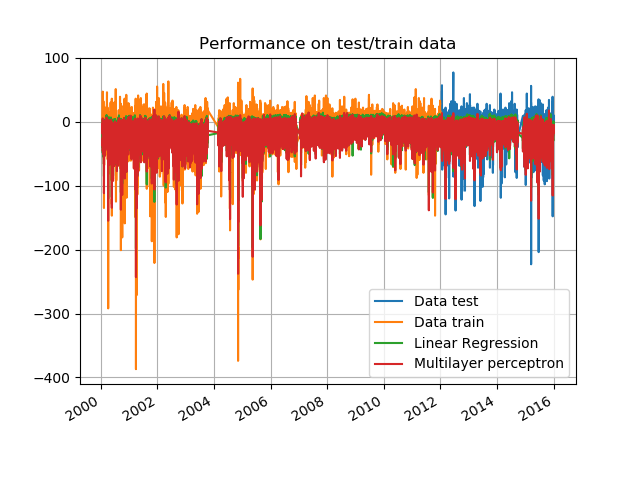

In [7]:
plt.figure()
plt.title('Performance on test/train data')
plt.plot(t_test, y_test, label='Data test')
plt.plot(t_train, y_train, label='Data train')
for model in models:
    p = plt.plot(t_test, model['test_predict'], label=model['name'])
    # Plot another line with the same color
    plt.plot(t_train, model['train_predict'], color=p[0].get_color())
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

## Working with a history to improve predictions

Before, we only used the 'instantaneous' values of other variables to predict the DST Index. We can improve predictions by keeping track of a history of values, for which we use the AIDApy preprocessing module.

In [8]:
from aidapy.ml import preprocess

histsize = 24                   # Number of past hours
forecast_time = 0               # Hours into the future

Xtr = dtrain[features].values
ytr = dtrain[targets].values
Xte = dtest[features].values
yte = dtest[targets].values

# Use the AIDApy preprocessing method for time series
X_train, y_train, mask_train = preprocess.time_series(
    Xtr, ytr, histsize, forecast_time)
X_test, y_test, mask_test = preprocess.time_series(
    Xte, yte, histsize, forecast_time)

t_train = dtrain.index[mask_train]
t_test = dtest.index[mask_test]

models_v2 = []

models_v2.append({
    'name': 'Linear Regression',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', LinearRegression())])
})

mlp_model = NeuralNetRegressor(
    mlp.RegressorMlp,
    max_epochs=20,
    lr=0.001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    module__layer_sizes=[X_train.shape[1], 64, 64, 64, 1]
)

models_v2.append({
    'name': 'Multilayer perceptron',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', mlp_model)])
})

## Training and evaluating the new models

In [9]:
for model in models_v2:
    model['pipe'].fit(X_train, y_train)
    model['test_predict'] = model['pipe'].predict(X_test)
    model['train_predict'] = model['pipe'].predict(X_train)
    
for model in models_v2:
    print("{:30} R2 score on test / train set:  {:8.3f} {:8.3f}".format(
        model['name'], r2_score(y_test, model['test_predict']),
        r2_score(y_train, model['train_predict'])))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      211.1822      320.4362  3.7218
      2      120.9668      272.9826  4.0578
      3      116.8801      265.6732  5.9941
      4      114.9084      249.5811  3.8256
      5      112.3243      244.7855  3.6040
      6      110.7551      240.7139  3.4175
      7      109.4082      237.4817  3.4066
      8      108.2381      234.2301  3.3303
      9      107.1030      231.2991  2.4646
     10      105.9993      228.7583  5.1124
     11      105.0800      226.6691  3.4773
     12      104.1000      224.7690  3.3862
     13      103.2819      222.9194  3.0130
     14      102.5243      221.2111  5.1869
     15      101.7451      219.7934  2.9591
     16      101.0786      218.5600  2.5240
     17      100.4546      216.9458  4.8371
     18       99.7634      215.4997  2.8842
     19       99.2128      214.3354  2.6664
     20       98.6472      213.3654  5.0065
Linear Regression              R

## Looking at the results

The performance of both models seems to have significantly improved by using a history of variables.

<IPython.core.display.Javascript object>


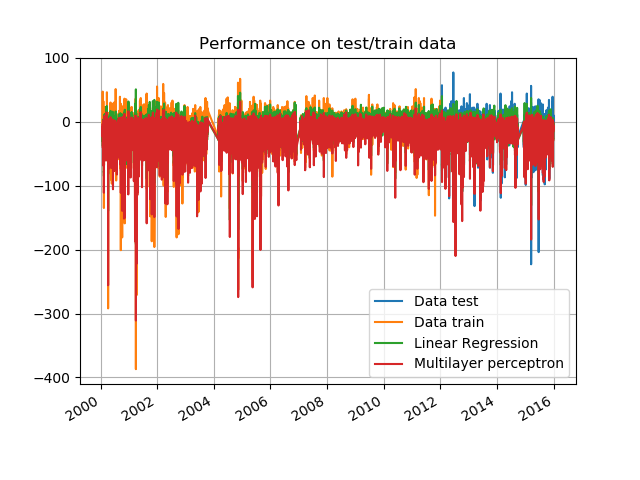

In [10]:
plt.figure()
plt.title('Performance on test/train data')
plt.plot(t_test, y_test, label='Data test')
plt.plot(t_train, y_train, label='Data train')
for model in models_v2:
    p = plt.plot(t_test, model['test_predict'], label=model['name'])
    # Plot another line with the same color
    plt.plot(t_train, model['train_predict'], color=p[0].get_color())
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

## Possible extensions

Above, features were selected based on their linear correlation to the DST index. Such features will work well for a linear model, but a neural network could potentially also use features that have a more complex correlation with the DST index. We could simply use all variables as the input for the neural network, but then we have to take care that there are no missing values (NaN's).